# 10-01: SkipGram Model and Word Embeddings

*June 26 2024*  

In [51]:
import torch
import torch.nn.functional as F
from torch.nn import Parameter
from torch import autograd
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import Counter

from sklearn.decomposition import TruncatedSVD

plt.style.use('default')
sns.set_style("whitegrid")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Running on', device)

Running on cuda


In [52]:
text = [
    'Gandalf is a Wizard',
    'Frodo is a Hobbit',
    'Sam is a Hobbit',
    'Saruman is a Wizard',
    'Sam lives in the Shire',
    'Frodo lives in the Shire',
    'Saruman lives in Isengard',
    'Gandalf is imprisoned in Isengard'
]

In [53]:
stopwords = ['a', 'the', 'in', 'is']

In [54]:
def tokenize(text, stopwords):
    tokens =  [sentence.split() for sentence in text]
    for s in tokens:
        for x in stopwords:
            if x in s:
                s.remove(x)
    return tokens

In [55]:
tokens = tokenize(text, stopwords)
print(tokens)

[['Gandalf', 'Wizard'], ['Frodo', 'Hobbit'], ['Sam', 'Hobbit'], ['Saruman', 'Wizard'], ['Sam', 'lives', 'Shire'], ['Frodo', 'lives', 'Shire'], ['Saruman', 'lives', 'Isengard'], ['Gandalf', 'imprisoned', 'Isengard']]


In [56]:
def build_vocabulary(tokens):
    vocab = []
    for sentence in tokens:
        for word in sentence:
            if word not in vocab:
                vocab.append(word)
    return vocab

In [57]:
vocab = build_vocabulary(tokens)
print(vocab)

['Gandalf', 'Wizard', 'Frodo', 'Hobbit', 'Sam', 'Saruman', 'lives', 'Shire', 'Isengard', 'imprisoned']


In [58]:
def build_word_context_pairs(tokens, window_size):
    pairs = []
    for sentence in tokens:
        for center in range(len(sentence)):
            for i in range(-window_size, window_size+1):
                context_word = center + i
                if context_word < 0 or context_word >= len(sentence) or center == context_word:
                    continue
                if sentence[center] in vocab and sentence[context_word] in vocab:
                    pairs.append((sentence[center], sentence[context_word]))
    return pairs

In [59]:
pairs = build_word_context_pairs(tokens, window_size=2)
print(Counter(pairs))

Counter({('lives', 'Shire'): 2, ('Shire', 'lives'): 2, ('Gandalf', 'Wizard'): 1, ('Wizard', 'Gandalf'): 1, ('Frodo', 'Hobbit'): 1, ('Hobbit', 'Frodo'): 1, ('Sam', 'Hobbit'): 1, ('Hobbit', 'Sam'): 1, ('Saruman', 'Wizard'): 1, ('Wizard', 'Saruman'): 1, ('Sam', 'lives'): 1, ('Sam', 'Shire'): 1, ('lives', 'Sam'): 1, ('Shire', 'Sam'): 1, ('Frodo', 'lives'): 1, ('Frodo', 'Shire'): 1, ('lives', 'Frodo'): 1, ('Shire', 'Frodo'): 1, ('Saruman', 'lives'): 1, ('Saruman', 'Isengard'): 1, ('lives', 'Saruman'): 1, ('lives', 'Isengard'): 1, ('Isengard', 'Saruman'): 1, ('Isengard', 'lives'): 1, ('Gandalf', 'imprisoned'): 1, ('Gandalf', 'Isengard'): 1, ('imprisoned', 'Gandalf'): 1, ('imprisoned', 'Isengard'): 1, ('Isengard', 'Gandalf'): 1, ('Isengard', 'imprisoned'): 1})


For all pairs $(w, c)$ of center words $w$ and context words $c$ we want to maximize the probability of the context word given the center word, i.e. 

$$P(c|w)$$

for all pairs $(w, c)$ or

$$max \prod_{w \in V} \prod_{c \in V} P(c|w)$$

Using a logarithmic transformation this corresponds to the minimization of the following loss function:

$$L = - \sum_{w \in V} \sum_{c \in V} \log P(c|w)$$

Let us now assume that each word $w$ is represented by a vector $\vec{w} \in \mathbb{R}^V$. We can use the dot product $\vec{w} \cdot \vec{c}$ to assess the similarity between center and context words. We can use use the softmax function to map the dot product between vectors to a probability, i.e. 

$$ P(c|w) = \frac{e^{\vec{c} \cdot \vec{w}}}{\sum_{j=1}^V e^{\vec{c_j} \cdot \vec{w}}} $$

The softmax function simply turns the dot product between words into a probability that is normalized in (0,1). Like for logistic regression, we obtain a log-linear model, i.e. we use a linear model for the log of the probabilities of the different class labels $c_i$ that we assign for a given "feature" $x$.

Our goal is to find a vector representation of center words $w$ that allow us to predict the context words. To achieve this, we can define a two-layer neural network, where (i) the center word $w$ is passed as a input, (ii) the hidden layer with $d$ dimensions contains the word embeddings, and (iii) a softmax layer transforms the dot product between word embeddings into probabilities.


Since our input is categorical, we use a one-hot encoding of the center words:

In [60]:
def get_ohe(word, vocab):
    word_idx = vocab.index(word)
    x = torch.zeros(1,len(vocab)).float()
    x[:,word_idx] = 1.0
    return x.to(device)

In [61]:
get_ohe('Frodo', vocab)

tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')

In [62]:
get_ohe('Gandalf', vocab)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')

We now specify the feed-forward neural network with two layers of linear perceptrons. For a vocabulary with $n$ words, we have $n$ inputs that take the one-hot-encodings of words. We add a first hidden layer with $d$ perceptrons. In this first layer we do not apply an activation function! We rather directly feed the outputs of the $d$ neurons in the first hidden layer into a second layer of $|V|$ neurons. The output of this linear layer is fed into a softmax activation function, which generates a normalized output. For a given input word $x$ passed as one-hot-encoding where the $i$-th component is one, we can now interpret the $j$-th output in the output layer as probability of the context word encoded in component $j$ given the center word encoded in component $i$.

It is easy to implement this model in `pytorch`:

In [63]:
class SkipGram(torch.nn.Module):
    
    # SkipGram model = predict context probabilities based on center word
    # input = one-hot-encoding of center word 
    # outputs y_i = conditional probabilities of context words $j$ given center word
    def __init__(self, embedding_dim, vocab_size):
        super(SkipGram, self).__init__()

        # The first layer has |V| * d learnable weights
        self.embeddings = torch.nn.Linear(vocab_size, embedding_dim)

        # The second layer has d * |V| learnable weights
        self.linear = torch.nn.Linear(embedding_dim, vocab_size)
        
    def forward(self, x):

        emb_x = self.embeddings(x)
        y = self.linear(emb_x)
        return F.softmax(y, dim=1)

Let us now create a SkipGram model where words have five-dimensional embeddings:

In [64]:
model = SkipGram(embedding_dim=5, vocab_size=len(vocab)).to(device)

Using the default params, we can input a one-hot encoding of a center word $x$. As output we get $V$ vectors $c_i \in \mathbb{R}^V$, where each vector $c_i$ captures the probabilities of all context words for a given center word $i$. Due to the one-hot encoding of our input, we are only interested in the output $c_i$ where $i$ corresponds to the non-zero index of our input vector.

In [65]:
x = get_ohe('Frodo', vocab)
model.forward(x)

tensor([[0.0772, 0.1317, 0.1021, 0.0981, 0.0838, 0.0731, 0.1052, 0.1047, 0.1002,
         0.1238]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

As expected, due to the softmax normalization the outputs sum to one:

In [66]:
sum(model.forward(x)[0])

tensor(1., device='cuda:0', grad_fn=<AddBackward0>)

Let's assume our actual context word for center word 'Frodo' is 'Hobbit'. We can compute a loss function for this specific (center, context) pair by calculating the Cross Entropy Loss with the one-hot encoding of the context word, i.e. 

In [67]:
loss_function = torch.nn.BCELoss()
context_ohe = get_ohe('Hobbit', vocab).float()
print(context_ohe)
prob = model.forward(x)
print(prob)
loss_function(prob, context_ohe)

tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
tensor([[0.0772, 0.1317, 0.1021, 0.0981, 0.0838, 0.0731, 0.1052, 0.1047, 0.1002,
         0.1238]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


tensor(0.3274, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)

To extract the embedding of a given center word, we can get the weights of the embedding layer that correspond to the index of the center word.

In [68]:
model.embeddings.weight.data[:,vocab.index('Frodo')]

tensor([-0.0906, -0.1994,  0.1759, -0.1103, -0.3036], device='cuda:0')

The weight parameters of the second linear layer provide us with a vector space representation of the associated context words:

In [69]:
model.linear.weight.data[vocab.index('Sam'),:]

tensor([ 0.1463, -0.0486, -0.0321, -0.4330, -0.2088], device='cuda:0')

In [72]:
model.linear.weight.data[vocab.index('Saruman'),:]

tensor([-0.4430,  0.2066,  0.2721, -0.1192, -0.3212], device='cuda:0')

We are now  ready to train our model, i.e. we use the gradients of the loss function for (center, context) pairs to update the model parameters, which gradually changes the weight parameters and thus the vector space embeddings of words.

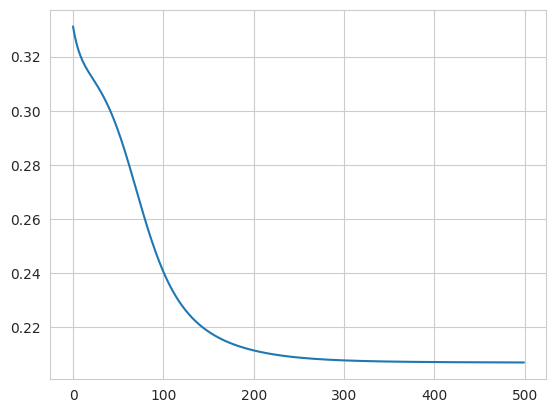

In [73]:
optimizer = optim.SGD(model.parameters(), lr=0.1)
epochs = 500
losses = []
for i in range(epochs):
    l = 0
    for center, context in pairs:
        model.zero_grad()
        prob = model.forward(get_ohe(center, vocab))
        loss = loss_function(prob, get_ohe(context, vocab).float())
        loss.backward()
        optimizer.step()        
        l += loss.data.to('cpu')

    losses.append(l/len(pairs))
plt.plot(range(epochs), losses)

Let's get the conditional probabilities of context words given center word `Frodo`:

In [74]:
model.forward(get_ohe('Frodo', vocab))

tensor([[2.8172e-03, 1.2529e-03, 3.2650e-03, 3.1824e-01, 1.8356e-03, 1.8922e-03,
         3.1960e-01, 3.4697e-01, 3.9177e-03, 2.0840e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

To simplify the interpretation of this vector, we use the following helper function:

In [75]:
def context_probs(word, vocab, model):
    return { x:p for x,p in zip(vocab, model.forward(get_ohe(word, vocab))[0].detach())}

In [76]:
context_probs('Frodo', vocab, model)

{'Gandalf': tensor(0.0028, device='cuda:0'),
 'Wizard': tensor(0.0013, device='cuda:0'),
 'Frodo': tensor(0.0033, device='cuda:0'),
 'Hobbit': tensor(0.3182, device='cuda:0'),
 'Sam': tensor(0.0018, device='cuda:0'),
 'Saruman': tensor(0.0019, device='cuda:0'),
 'lives': tensor(0.3196, device='cuda:0'),
 'Shire': tensor(0.3470, device='cuda:0'),
 'Isengard': tensor(0.0039, device='cuda:0'),
 'imprisoned': tensor(0.0002, device='cuda:0')}

In [77]:
context_probs('Saruman', vocab, model)

{'Gandalf': tensor(0.0033, device='cuda:0'),
 'Wizard': tensor(0.3020, device='cuda:0'),
 'Frodo': tensor(0.0020, device='cuda:0'),
 'Hobbit': tensor(0.0049, device='cuda:0'),
 'Sam': tensor(0.0022, device='cuda:0'),
 'Saruman': tensor(0.0002, device='cuda:0'),
 'lives': tensor(0.3092, device='cuda:0'),
 'Shire': tensor(0.0032, device='cuda:0'),
 'Isengard': tensor(0.3623, device='cuda:0'),
 'imprisoned': tensor(0.0105, device='cuda:0')}

In [78]:
context_probs('Shire', vocab, model)

{'Gandalf': tensor(0.0003, device='cuda:0'),
 'Wizard': tensor(0.0007, device='cuda:0'),
 'Frodo': tensor(0.2371, device='cuda:0'),
 'Hobbit': tensor(0.0013, device='cuda:0'),
 'Sam': tensor(0.2229, device='cuda:0'),
 'Saruman': tensor(0.0037, device='cuda:0'),
 'lives': tensor(0.5264, device='cuda:0'),
 'Shire': tensor(0.0055, device='cuda:0'),
 'Isengard': tensor(0.0014, device='cuda:0'),
 'imprisoned': tensor(0.0009, device='cuda:0')}

We can use the following function to extract a vector space representation of a center word based on the learned weight parameters of the trained model:

In [79]:
def get_embedding(word, model, vocab):
    return model.embeddings.weight.data[:,vocab.index(word)]


In [80]:
get_embedding('Frodo', model, vocab)

tensor([ 0.6832, -0.8268, -0.1250,  1.6665, -1.0807], device='cuda:0')

In [81]:
get_embedding('Gandalf', model, vocab)

tensor([-0.5005, -1.1610, -0.8084, -1.3133,  1.1131], device='cuda:0')

We can use cosine similarity to quantify the similarity between different words:

In [82]:
cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)

In [83]:
cos(get_embedding('Frodo', model, vocab), get_embedding('Shire', model, vocab))

tensor(0.0743, device='cuda:0')

In [84]:
cos(get_embedding('Frodo', model, vocab), get_embedding('Isengard', model, vocab))

tensor(-0.3536, device='cuda:0')

In [85]:
cos(get_embedding('Frodo', model, vocab), get_embedding('Sam', model, vocab))

tensor(0.9992, device='cuda:0')

In [86]:
cos(get_embedding('Gandalf', model, vocab), get_embedding('Saruman', model, vocab))

tensor(0.4089, device='cuda:0')

In [87]:
cos(get_embedding('Gandalf', model, vocab), get_embedding('Sam', model, vocab))

tensor(-0.5431, device='cuda:0')

Since we have learned word representations in a five-dimensional space, we need to apply additional dimensionality reduction techniques to obtain a meaningful two-dimensional visualization of the embedding:

In [89]:
svd = TruncatedSVD()
low_dim = svd.fit_transform(np.array([ get_embedding(w, model, vocab).detach().cpu().numpy() for w in vocab]))

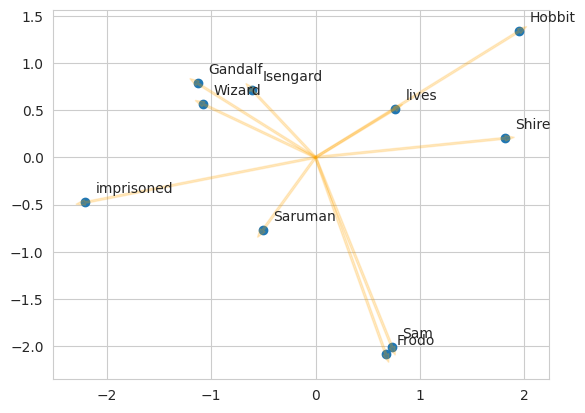

In [90]:
fig, ax = plt.subplots()
ax.scatter(low_dim[:,0], low_dim[:,1])

for i, txt in enumerate(vocab):
    plt.arrow(0, 0, low_dim[i,0], low_dim[i,1], color='orange', width=0.02, alpha=0.2)
    ax.annotate(txt, (low_dim[i,0]+0.1, low_dim[i,1]+0.1))

We can use the following function to obtain the word that is semantically closest to a given word:

In [91]:
def closest_word(word, vocab, model):
    max_u = None
    max_sim = 0
    for u in vocab:
        sim = cos(get_embedding(word, model, vocab), get_embedding(u, model, vocab))
        if sim>max_sim and u != word:
            max_sim = sim
            max_u = u
    return max_u

In [92]:
closest_word('Frodo', vocab, model)

'Sam'

In [93]:
closest_word('Gandalf', vocab, model)

'Saruman'

In [94]:
def get_context_embedding(word, model, vocab):
    return model.linear.weight.data[vocab.index(word),:]

In [96]:
svd = TruncatedSVD()
low_dim = svd.fit_transform(np.array([ get_context_embedding(w, model, vocab).detach().cpu().numpy() for w in vocab]))

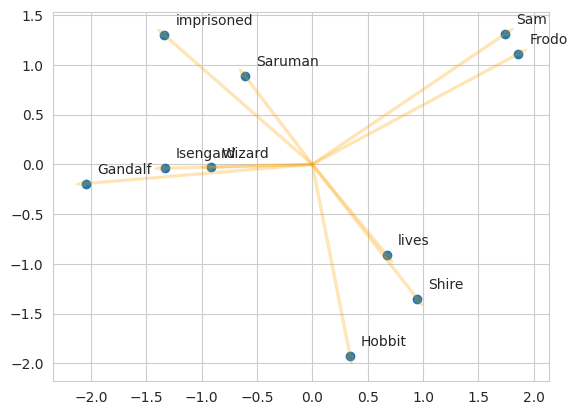

In [97]:
fig, ax = plt.subplots()
ax.scatter(low_dim[:,0], low_dim[:,1])

for i, txt in enumerate(vocab):
    plt.arrow(0, 0, low_dim[i,0], low_dim[i,1], color='orange', width=0.02, alpha=0.2)
    ax.annotate(txt, (low_dim[i,0]+0.1, low_dim[i,1]+0.1))